# Self-Driving Car Engineer Nanodegree

## Deep Learning

## Project: Build a Traffic Sign Recognition Classifier

In this notebook, a template is provided for you to implement your functionality in stages, which is required to successfully complete this project. If additional code is required that cannot be included in the notebook, be sure that the Python code is successfully imported and included in your submission if necessary. 

> **Note**: Once you have completed all of the code implementations, you need to finalize your work by exporting the iPython Notebook as an HTML document. Before exporting the notebook to html, all of the code cells need to have been run so that reviewers can see the final implementation and output. You can then export the notebook by using the menu above and navigating to  \n",
    "**File -> Download as -> HTML (.html)**. Include the finished document along with this notebook as your submission. 

In addition to implementing code, there is a writeup to complete. The writeup should be completed in a separate file, which can be either a markdown file or a pdf document. There is a [write up template](https://github.com/udacity/CarND-Traffic-Sign-Classifier-Project/blob/master/writeup_template.md) that can be used to guide the writing process. Completing the code template and writeup template will cover all of the [rubric points](https://review.udacity.com/#!/rubrics/481/view) for this project.

The [rubric](https://review.udacity.com/#!/rubrics/481/view) contains "Stand Out Suggestions" for enhancing the project beyond the minimum requirements. The stand out suggestions are optional. If you decide to pursue the "stand out suggestions", you can include the code in this Ipython notebook and also discuss the results in the writeup file.


>**Note:** Code and Markdown cells can be executed using the **Shift + Enter** keyboard shortcut. In addition, Markdown cells can be edited by typically double-clicking the cell to enter edit mode.

---
## Step 0: Load The Data

##### First we download the data

In [1]:
import os
from urllib.request import urlretrieve

def download(url, file):
    """
    Download file from <url>
    :param url: URL to file
    :param file: Local file path
    """
    if not os.path.isfile(file):
        print('Downloading ' + file + '...')
        urlretrieve(url, file)
        print('Download Finished')

# Download the training and test dataset.
download('https://d17h27t6h515a5.cloudfront.net/topher/2017/February/5898cd6f_traffic-signs-data/traffic-signs-data.zip', 'data.zip')

print('All files downloaded.')

All files downloaded.


#### The training Data set has now been downloaded
- Now we unzip it 

In [2]:
import zipfile
import os
print ("Unzipping training data ....")
if not os.path.isdir('data'):
    zip_ref = zipfile.ZipFile('data.zip', 'r')
    zip_ref.extractall('data')
    zip_ref.close()
print ("Training extracted to folder data")

Unzipping training data ....
Training extracted to folder data


#### Now we load the data

In [1]:
# Load pickled data
import pickle


training_file = 'data/train.p'
validation_file= 'data/valid.p'
testing_file = 'data/test.p'

with open(training_file, mode='rb') as f:
    train = pickle.load(f)
with open(validation_file, mode='rb') as f:
    valid = pickle.load(f)
with open(testing_file, mode='rb') as f:
    test = pickle.load(f)
    
X_train, y_train = train['features'], train['labels']
X_validation, y_validation = valid['features'], valid['labels']
X_test, y_test = test['features'], test['labels']

#### We Also open the csv file containing label names

In [2]:
import csv
label_names = {}
with open('signnames.csv', mode='r') as infile:
    reader = csv.reader(infile)
    for rows in reader:
        label_names[str(rows[0])] = rows[1]

---

## Step 1: Dataset Summary & Exploration

The pickled data is a dictionary with 4 key/value pairs:

- `'features'` is a 4D array containing raw pixel data of the traffic sign images, (num examples, width, height, channels).
- `'labels'` is a 1D array containing the label/class id of the traffic sign. The file `signnames.csv` contains id -> name mappings for each id.
- `'sizes'` is a list containing tuples, (width, height) representing the original width and height the image.
- `'coords'` is a list containing tuples, (x1, y1, x2, y2) representing coordinates of a bounding box around the sign in the image. **THESE COORDINATES ASSUME THE ORIGINAL IMAGE. THE PICKLED DATA CONTAINS RESIZED VERSIONS (32 by 32) OF THESE IMAGES**

Complete the basic data summary below. Use python, numpy and/or pandas methods to calculate the data summary rather than hard coding the results. For example, the [pandas shape method](http://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.shape.html) might be useful for calculating some of the summary results. 

### Provide a Basic Summary of the Data Set Using Python, Numpy and/or Pandas

In [6]:
# Some variables to ensure some operations are run only once
is_augmented = False
is_normalized = False

In [7]:
### Replace each question mark with the appropriate value. 
### Use python, pandas or numpy methods rather than hard coding the results

# TODO: Number of training examples
n_train = len(X_train)

# TODO: Number of validation examples
n_validation = len(X_validation)

# TODO: Number of testing examples.
n_test = len(X_test)

# TODO: What's the shape of an traffic sign image?
image_shape = X_train[0].shape

# TODO: How many unique classes/labels there are in the dataset.
n_classes = 43

print("Number of training examples =", n_train)
print("Number of testing examples =", n_test)
print("Image data shape =", image_shape)
print("Number of classes =", n_classes)

Number of training examples = 34799
Number of testing examples = 12630
Image data shape = (32, 32, 3)
Number of classes = 43


### Include an exploratory visualization of the dataset

Class Distribution for training set


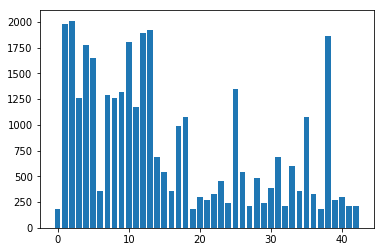

Class Distribution for test set


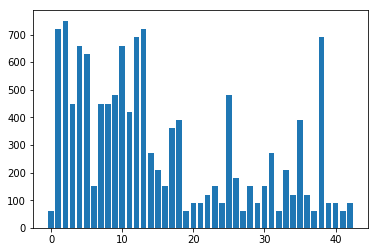

Class Distribution for validation set


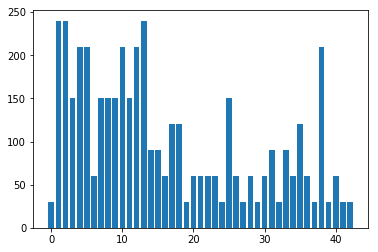

In [8]:
import numpy as np

### Data exploration visualization code goes here.
### Feel free to use as many code cells as needed.
import matplotlib.pyplot as plt
# Visualizations will be shown in the notebook.
%matplotlib inline
num_train_labels = []
num_test_labels = []
num_valid_labels = []
for i in range(0,43):
    num_train_labels.append(np.sum(y_train == i))
    num_test_labels.append(np.sum(y_test == i))
    num_valid_labels.append(np.sum(y_validation == i))
print ("Class Distribution for training set")
plt.bar(range(0,43), num_train_labels)
plt.show()
print ("Class Distribution for test set")
plt.bar(range(0,43), num_test_labels)
plt.show()
print ("Class Distribution for validation set")
plt.bar(range(0,43), num_valid_labels)
plt.show()

## Analysis of the training data:
In the Training set we see that some of the classes have much less representation. Some classes have as many as 2000 samples while some have less than 200.
- Next we augment the data set by processing the underrepresented classes and adding them back to the training set

## Augment the training set
The training set is augmented by first choosing the classes which are represented by less than 500 samples. Then they are processed by one of the three techniques below:
- Sharpening the image
- Translating the image by random pixel values below 5 pixels in both horizantle and vertical directions
- Rotating the image by an angle less than 16 degrees

#### Below are a few helper functions used to accomplish this

In [9]:
# Helper functions to augment the data set
import numpy as np
import cv2
from scipy.ndimage.interpolation import rotate

def rotate_random(src):
    """
    Rotate the image by a random small angle
    between -16 and 16 degrees.
    
    Args: src - Source image to be rotated
    Returns: Rotated image with same dimensions
    """
    np.random.seed(42)
    random_angle = np.random.randint(-16, 16)
    return rotate(src, random_angle, mode='nearest', reshape=False)

def sharpen(src):
    """
    Sharpen the given image
    Args: src - Source image to be sharpened
    Returns: The sharpened image
    """
    np.random.seed(42)
    kernel_sharpen_1 = np.array([[-1,-1,-1], [-1,9,-1], [-1,-1,-1]])
    return cv2.filter2D(src, -1, kernel_sharpen_1)

def translate_random(src):
    """
    Translate in the given image by a random pixel value
    between 5 pixels in all four directions
    
    Args: src - Source image to be translated
    Returns: The translated image
    """
    np.random.seed(42)
    rand_x = np.random.randint(-5,5)
    rand_y = np.random.randint(-5,5)
    translation_matrix = np.float32([ [1,0,rand_x], [0,1,rand_y]])
    return cv2.warpAffine(src, translation_matrix, (32, 32))

##### Now we use these functions to augment the training data

In [10]:
# We want this to happen only once 
print ("Augmenting the data set....")
if not is_augmented:
    x_append = []
    y_append = []
    count = 0;
    for i in range(0,43):
        if num_train_labels[i] < 500:
            for x,l in zip(X_train, y_train):
                if l == i:
                    count += 1
                    if count % 3 == 0:
                        x_append.append(sharpen(x))
                    if count % 3 == 1:
                        x_append.append(translate_random(x))
                    if count % 3 == 2:
                        x_append.append(rotate_random(x))
                    y_append.append(l)
    X_train = np.append(X_train, x_append, axis=0)
    y_train = np.append(y_train, y_append, axis=0)
    augmented = True
print ("Done!")
print (X_train.shape, y_train.shape)

Augmenting the data set....
Done!
(40859, 32, 32, 3) (40859,)


#### Visualising the new dataset:

Class Distribution for training set


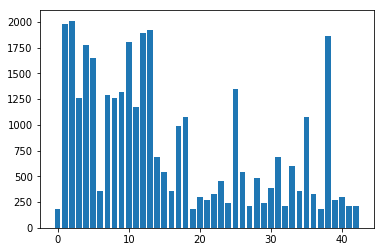

In [10]:
import numpy as np

import matplotlib.pyplot as plt

%matplotlib inline
num_train_labels = []
for i in range(0,43):
    num_train_labels.append(np.sum(y_train == i))

print ("Class Distribution for training set")
plt.bar(range(0,43), num_train_labels)
plt.show()

----

## Step 2: Design and Test a Model Architecture

Design and implement a deep learning model that learns to recognize traffic signs. Train and test your model on the [German Traffic Sign Dataset](http://benchmark.ini.rub.de/?section=gtsrb&subsection=dataset).

The LeNet-5 implementation shown in the [classroom](https://classroom.udacity.com/nanodegrees/nd013/parts/fbf77062-5703-404e-b60c-95b78b2f3f9e/modules/6df7ae49-c61c-4bb2-a23e-6527e69209ec/lessons/601ae704-1035-4287-8b11-e2c2716217ad/concepts/d4aca031-508f-4e0b-b493-e7b706120f81) at the end of the CNN lesson is a solid starting point. You'll have to change the number of classes and possibly the preprocessing, but aside from that it's plug and play! 

With the LeNet-5 solution from the lecture, you should expect a validation set accuracy of about 0.89. To meet specifications, the validation set accuracy will need to be at least 0.93. It is possible to get an even higher accuracy, but 0.93 is the minimum for a successful project submission. 

There are various aspects to consider when thinking about this problem:

- Neural network architecture (is the network over or underfitting?)
- Play around preprocessing techniques (normalization, rgb to grayscale, etc)
- Number of examples per label (some have more than others).
- Generate fake data.

Here is an example of a [published baseline model on this problem](http://yann.lecun.com/exdb/publis/pdf/sermanet-ijcnn-11.pdf). It's not required to be familiar with the approach used in the paper but, it's good practice to try to read papers like these.

### Pre-process the Data Set (normalization, grayscale, etc.)

Minimally, the image data should be normalized so that the data has mean zero and equal variance. For image data, `(pixel - 128)/ 128` is a quick way to approximately normalize the data and can be used in this project. 

Other pre-processing steps are optional. You can try different techniques to see if it improves performance. 

Use the code cell (or multiple code cells, if necessary) to implement the first step of your project.

In [11]:
import numpy as np

def rgb2gray(rgb):
    return np.dot(rgb[...,:3], [0.299, 0.587, 0.114])

def normalize(img):
    """
    Normalize the image data with Min-Max scaling to a range of [-0.5, 0.5]
    Args: The image to be normalized
    return: Normalized image data
    """
    img = rgb2gray(img)
    normalized = (img)/255.0 - 0.5
    normalized = normalized.reshape((-1,32,32,1))
    return normalized.astype(np.float32)

# Ensure image data is normalized only once
if not is_normalized:
    X_train = normalize(X_train)
    X_validation = normalize(X_validation)
    X_test = normalize(X_test)
    is_normalized = True

print ("The new image shape is:",X_train[0].shape)

The new image shape is: (32, 32, 1)


In [12]:
# Shuffle the training set
from sklearn.utils import shuffle

X_train, y_train = shuffle(X_train, y_train)

### Model Architecture

#### The model used to make the neural network consists of the following layers
- The input image of size 32x32x1
- 3x3 Convolution layer (Input = 32x32x1, Output=30x30x6)
- A Relu Activation layer (Input = 30x30x6, Output=30x30x6)
- 3x3 Convolution layer (Input = 30x30x6, Output=28x28x16)
- A Relu Activation layer (Input = 30x30x6, Output=28x28x16)
- Max Pooling Operation (Input = 28x28x16, Output=14x14x16)
- 5x5 Convolution layer (Input = 14x14x16, Output=10x10x32)
- Max Pooling Operation (Input = 10x10x32, Output=5x5x32)
- The above layer is flattened (Input = 5x5x32, Output=800)
- Fully Connected Layer (Input = 800, Output=240)
- A Relu Activation layer (Input = 240, Output=240) followed by dropout while training
- Fully Connected Layer (Input = 240, Output=120)
- A Relu Activation layer (Input = 120, Output=120) followed by dropout while training
- Finally a Fully Connected Layer with (Input = 120 - 43 logits)

#### Below a dictionary with weights and biases to be used is defined

In [13]:
import tensorflow as tf
def init_weights_biases():
    mu = 0.0
    sigma = 0.1

    weights = {
        'c1' : tf.Variable(tf.truncated_normal(shape=(3, 3, 1, 6), mean=mu, stddev=sigma)),
        'c2' : tf.Variable(tf.truncated_normal(shape=(3, 3, 6, 16), mean=mu, stddev=sigma)),
        'c3' : tf.Variable(tf.truncated_normal(shape=(5, 5, 16, 32), mean=mu, stddev=sigma)),
        'fc1' : tf.Variable(tf.truncated_normal(shape=(800, 240), mean=mu, stddev=sigma)),
        'fc2' : tf.Variable(tf.truncated_normal(shape=(240, 120), mean=mu, stddev=sigma)),
        'fc3' : tf.Variable(tf.truncated_normal(shape=(120, 43), mean=mu, stddev=sigma))
    }

    biases = {
        'c1' : tf.Variable(tf.zeros(6)),
        'c2' : tf.Variable(tf.zeros(16)),
        'c3' : tf.Variable(tf.zeros(32)),
        'fc1' : tf.Variable(tf.zeros(240)),
        'fc2' : tf.Variable(tf.zeros(120)),
        'fc3' : tf.Variable(tf.zeros(43)),
    }
    return weights,biases
    

In [14]:
import tensorflow as tf
from tensorflow.contrib.layers import flatten

def Net(x, weights, biases, keep_prob):
    
    # Convulution Layer 32x32x1 - 30x30x6
    conv1 = tf.nn.conv2d(x,
                        weights['c1'],
                        strides=[1,1,1,1],
                        padding='VALID') + biases['c1']
    # Activation
    conv1 = tf.nn.relu(conv1)
    
    # Convolution Layer 30x30x6 - 28x28x16
    conv2 = tf.nn.conv2d(conv1,
                        weights['c2'],
                        strides=[1,1,1,1],
                        padding='VALID') + biases['c2']
    
    # Activation
    conv2 = tf.nn.relu(conv2)
    
    # Pooling Layer 28x28x16 - 14x14x16
    conv2 = tf.nn.max_pool(conv2,
                          ksize = [1,2,2,1],
                          strides=[1,2,2,1],
                          padding='VALID')
    
    # Convolution Layer 14x14x16 - 10x10x32
    conv3 = tf.nn.conv2d(conv2,
                        weights['c3'],
                        strides=[1,1,1,1],
                        padding='VALID') + biases['c3']
    
    # Activation 
    conv3 = tf.nn.relu(conv3)
    
    # Pooling layer 10x10x32 - 5x5x32
    conv3 = tf.nn.max_pool(conv3, 
                          ksize=[1,2,2,1],
                          strides=[1,2,2,1],
                          padding='VALID')
    
    # Flatten 5x5x32 - 800
    fc0 = flatten(conv3)
    
    # Fully connected 800 - 240
    fc1 = tf.matmul(fc0, weights['fc1']) + biases['fc1']
    
    # Activation
    fc1 = tf.nn.relu(fc1)
    
    # Dropout
    fc1 = tf.nn.dropout(fc1, keep_prob=keep_prob)
    
    # Fully connected 240 - 120
    fc2 = tf.matmul(fc1, weights['fc2']) + biases['fc2']
    
    # Activation
    fc2 = tf.nn.relu(fc2)
    
    # Dropout
    fc2 = tf.nn.dropout(fc2, keep_prob=keep_prob)
    
    # Fully connected 120 - 43
    logits = tf.matmul(fc2, weights['fc3']) + biases['fc3']
    return logits

### Train, Validate and Test the Model

A validation set can be used to assess how well the model is performing. A low accuracy on the training and validation
sets imply underfitting. A high accuracy on the training set but low accuracy on the validation set implies overfitting.

In [15]:
# Params to be used while training
rate = 0.001
EPOCHS = 10
BATCH_SIZE = 128

In [16]:
# Place Holders for training batches
x = tf.placeholder(tf.float32, (None, 32, 32, 1))
y = tf.placeholder(tf.int32, (None))
one_hot_y = tf.one_hot(y, 43)

In [17]:
dropout = tf.placeholder(tf.float32)
weights, biases = init_weights_biases()
logits = Net(x, weights, biases, keep_prob=dropout)
cross_entropy = tf.nn.softmax_cross_entropy_with_logits(labels=one_hot_y,
                                                        logits=logits)
loss_operation = tf.reduce_mean(cross_entropy)
optimizer = tf.train.AdamOptimizer(learning_rate=rate)
training_operation = optimizer.minimize(loss_operation)

In [18]:
correct_prediction = tf.equal(tf.argmax(logits, 1), tf.argmax(one_hot_y, 1))
accuracy_operation = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
saver = tf.train.Saver()

def evaluate(X_data, y_data):
    num_examples = len(X_data)
    total_accuracy = 0
    sess = tf.get_default_session()
    for offset in range(0, num_examples, BATCH_SIZE):
        batch_x, batch_y = X_data[offset:offset+BATCH_SIZE], y_data[offset:offset+BATCH_SIZE]
        accuracy = sess.run(accuracy_operation, feed_dict={x: batch_x, y: batch_y, dropout:1.0})
        total_accuracy += (accuracy * len(batch_x))
    return total_accuracy / num_examples

In [19]:
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    num_examples = len(X_train)
    
    print("Training...")
    print()
    for i in range(EPOCHS):
        X_train, y_train = shuffle(X_train, y_train)
        for offset in range(0, num_examples, BATCH_SIZE):
            end = offset + BATCH_SIZE
            batch_x, batch_y = X_train[offset:end], y_train[offset:end]
            sess.run(training_operation, feed_dict={x: batch_x, y: batch_y, dropout:0.7})
            
        validation_accuracy = evaluate(X_validation, y_validation)
        training_accuracy = evaluate(X_train, y_train)
        print("EPOCH {} ...".format(i+1))
        print("Validation Accuracy = {:.3f}".format(validation_accuracy))
        print("Training Accuracy = {:.3f}".format(training_accuracy))
        print()
        
    saver.save(sess, './traffic')
    print("Model saved")

Training...

EPOCH 1 ...
Validation Accuracy = 0.808
Training Accuracy = 0.864

EPOCH 2 ...
Validation Accuracy = 0.912
Training Accuracy = 0.957

EPOCH 3 ...
Validation Accuracy = 0.930
Training Accuracy = 0.978

EPOCH 4 ...
Validation Accuracy = 0.934
Training Accuracy = 0.987

EPOCH 5 ...
Validation Accuracy = 0.949
Training Accuracy = 0.993

EPOCH 6 ...
Validation Accuracy = 0.948
Training Accuracy = 0.994

EPOCH 7 ...
Validation Accuracy = 0.956
Training Accuracy = 0.996

EPOCH 8 ...
Validation Accuracy = 0.959
Training Accuracy = 0.997

EPOCH 9 ...
Validation Accuracy = 0.950
Training Accuracy = 0.997

EPOCH 10 ...
Validation Accuracy = 0.959
Training Accuracy = 0.998

Model saved


In [19]:
import tensorflow as tf
with tf.Session() as sess:
    saver.restore(sess, tf.train.latest_checkpoint('.'))

    test_accuracy = evaluate(X_test, y_test)
    print("Test Accuracy = {:.3f}".format(test_accuracy))

Test Accuracy = 0.951


---

## Step 3: Test a Model on New Images

To give yourself more insight into how your model is working, download at least five pictures of German traffic signs from the web and use your model to predict the traffic sign type.

You may find `signnames.csv` useful as it contains mappings from the class id (integer) to the actual sign name.

### Load and Output the Images

In [42]:
import matplotlib.image as mpimg
import os

def load_images_from_folder(folder):
    images = []
    for filename in os.listdir(folder):
        img = mpimg.imread(os.path.join(folder,filename))
        if img is not None:
            images.append(img)
    return np.array(images)

Children Crossing


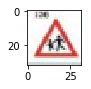

Speed limit (60km/h)


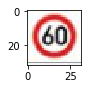

General Caution


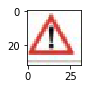

Cross Road of Junction


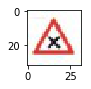

Dangerous curve to the right


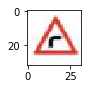

In [50]:
images = load_images_from_folder("SampleImages")
given_labels = ['Children Crossing',
                 'Speed limit (60km/h)',
                 'General Caution',
                 'Cross Road of Junction',
                 'Dangerous curve to the right']
for l,img in zip(given_labels,images):
    plt.figure(figsize=(1,1))
    print (l)
    plt.imshow(img)
    plt.show()

### Predict the Sign Type for Each Image

In [44]:
### Run the predictions here and use the model to output the prediction for each image.
### Make sure to pre-process the images with the same pre-processing pipeline used earlier.
### Feel free to use as many code cells as needed.

In [45]:
normalized_images = normalize(images)

In [47]:
with tf.Session() as sess:
    saver.restore(sess, tf.train.latest_checkpoint('.'))
    logits_prediction = sess.run(logits, feed_dict={
        x:normalized_images,
        dropout:1.0
    })
    labels_prediction = np.argmax(logits_prediction, axis=1)

In [65]:
for pl,al in zip(labels_prediction, given_labels):
    print ("Predicted Label : ", label_names[str(pl)])
    print ("Actual Label    : ", al)

Predicted Label :  Children crossing
Actual Label    :  Children Crossing
Predicted Label :  Speed limit (60km/h)
Actual Label    :  Speed limit (60km/h)
Predicted Label :  General caution
Actual Label    :  General Caution
Predicted Label :  Beware of ice/snow
Actual Label    :  Cross Road of Junction
Predicted Label :  Dangerous curve to the right
Actual Label    :  Dangerous curve to the right


### Analyze Performance

In [ ]:
### Calculate the accuracy for these 5 new images. 
### For example, if the model predicted 1 out of 5 signs correctly, it's 20% accurate on these new images.

As you can see the model predicts 4 out of 5 signs correctly. The one image it gets wrong is of the "Cross Road of Junction" sign which is not present in out data set. The model wrongly classifies it as one for "Beware of ice/snow" which is really similar to the test image downloaded from the web. 

Hence the model is 80% accurate on these new images

### Output Top 5 Softmax Probabilities For Each Image Found on the Web

For each of the new images, print out the model's softmax probabilities to show the **certainty** of the model's predictions (limit the output to the top 5 probabilities for each image). [`tf.nn.top_k`](https://www.tensorflow.org/versions/r0.12/api_docs/python/nn.html#top_k) could prove helpful here. 

The example below demonstrates how tf.nn.top_k can be used to find the top k predictions for each image.

`tf.nn.top_k` will return the values and indices (class ids) of the top k predictions. So if k=3, for each sign, it'll return the 3 largest probabilities (out of a possible 43) and the correspoding class ids.

Take this numpy array as an example. The values in the array represent predictions. The array contains softmax probabilities for five candidate images with six possible classes. `tk.nn.top_k` is used to choose the three classes with the highest probability:

```
# (5, 6) array
a = np.array([[ 0.24879643,  0.07032244,  0.12641572,  0.34763842,  0.07893497,
         0.12789202],
       [ 0.28086119,  0.27569815,  0.08594638,  0.0178669 ,  0.18063401,
         0.15899337],
       [ 0.26076848,  0.23664738,  0.08020603,  0.07001922,  0.1134371 ,
         0.23892179],
       [ 0.11943333,  0.29198961,  0.02605103,  0.26234032,  0.1351348 ,
         0.16505091],
       [ 0.09561176,  0.34396535,  0.0643941 ,  0.16240774,  0.24206137,
         0.09155967]])
```

Running it through `sess.run(tf.nn.top_k(tf.constant(a), k=3))` produces:

```
TopKV2(values=array([[ 0.34763842,  0.24879643,  0.12789202],
       [ 0.28086119,  0.27569815,  0.18063401],
       [ 0.26076848,  0.23892179,  0.23664738],
       [ 0.29198961,  0.26234032,  0.16505091],
       [ 0.34396535,  0.24206137,  0.16240774]]), indices=array([[3, 0, 5],
       [0, 1, 4],
       [0, 5, 1],
       [1, 3, 5],
       [1, 4, 3]], dtype=int32))
```

Looking just at the first row we get `[ 0.34763842,  0.24879643,  0.12789202]`, you can confirm these are the 3 largest probabilities in `a`. You'll also notice `[3, 0, 5]` are the corresponding indices.

In [64]:
with tf.Session() as sess:
    saver.restore(sess, tf.train.latest_checkpoint('.'))
    predicted_logits = sess.run(logits, feed_dict={
        x:normalized_images,
        dropout:1.0
    })
    args = tf.placeholder(tf.float32)
    softmaxx = sess.run(tf.nn.softmax(args), feed_dict={
        args:predicted_logits
    })
    top_5 = sess.run(tf.nn.top_k(tf.constant(softmaxx), k=5))


Correct label:  Children Crossing
Predicted label:  Children crossing


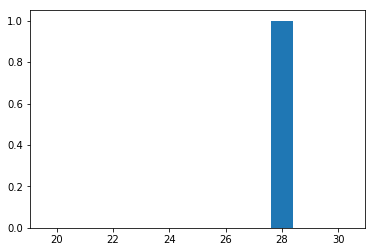

Correct label:  Speed limit (60km/h)
Predicted label:  Speed limit (60km/h)


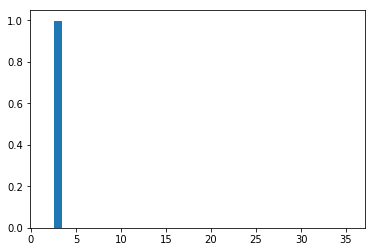

Correct label:  General Caution
Predicted label:  General caution


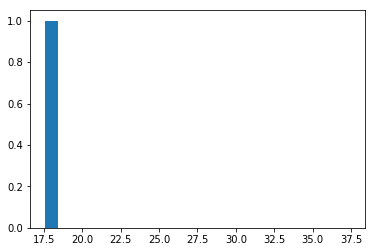

Correct label:  Cross Road of Junction
Predicted label:  Beware of ice/snow


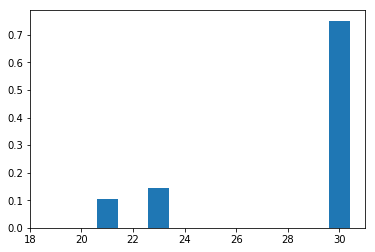

Correct label:  Dangerous curve to the right
Predicted label:  Dangerous curve to the right


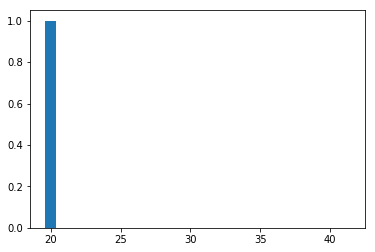

In [73]:
import matplotlib.pyplot as plt
i = 0
for v,l in zip(top_5.values, top_5.indices):
    print ("Correct label: ", given_labels[i])
    print ("Predicted label: ", label_names[str(l[0])])
    i += 1
    plt.bar(l,v)
    plt.show()

### Analysis of the top five softmax probablities:
- On the samples where the model correctly predicts the class, it very sure about the correct class having a softmax probablity of almost 1 on the correct class and almost 0 on rest of the classes
- On the sample where the model incorrectly predicts the class, the softmax probability of the class it predicted is ~0.7 and it has some significant softmax probablity over rest of top four candidate classes. In other words its a little bit confused 

> **Note**: Once you have completed all of the code implementations and successfully answered each question above, you may finalize your work by exporting the iPython Notebook as an HTML document. You can do this by using the menu above and navigating to  \n",
    "**File -> Download as -> HTML (.html)**. Include the finished document along with this notebook as your submission.

---

## Step 4 (Optional): Visualize the Neural Network's State with Test Images

 This Section is not required to complete but acts as an additional excersise for understaning the output of a neural network's weights. While neural networks can be a great learning device they are often referred to as a black box. We can understand what the weights of a neural network look like better by plotting their feature maps. After successfully training your neural network you can see what it's feature maps look like by plotting the output of the network's weight layers in response to a test stimuli image. From these plotted feature maps, it's possible to see what characteristics of an image the network finds interesting. For a sign, maybe the inner network feature maps react with high activation to the sign's boundary outline or to the contrast in the sign's painted symbol.

 Provided for you below is the function code that allows you to get the visualization output of any tensorflow weight layer you want. The inputs to the function should be a stimuli image, one used during training or a new one you provided, and then the tensorflow variable name that represents the layer's state during the training process, for instance if you wanted to see what the [LeNet lab's](https://classroom.udacity.com/nanodegrees/nd013/parts/fbf77062-5703-404e-b60c-95b78b2f3f9e/modules/6df7ae49-c61c-4bb2-a23e-6527e69209ec/lessons/601ae704-1035-4287-8b11-e2c2716217ad/concepts/d4aca031-508f-4e0b-b493-e7b706120f81) feature maps looked like for it's second convolutional layer you could enter conv2 as the tf_activation variable.

For an example of what feature map outputs look like, check out NVIDIA's results in their paper [End-to-End Deep Learning for Self-Driving Cars](https://devblogs.nvidia.com/parallelforall/deep-learning-self-driving-cars/) in the section Visualization of internal CNN State. NVIDIA was able to show that their network's inner weights had high activations to road boundary lines by comparing feature maps from an image with a clear path to one without. Try experimenting with a similar test to show that your trained network's weights are looking for interesting features, whether it's looking at differences in feature maps from images with or without a sign, or even what feature maps look like in a trained network vs a completely untrained one on the same sign image.

<figure>
 <img src="visualize_cnn.png" width="380" alt="Combined Image" />
 <figcaption>
 <p></p> 
 <p style="text-align: center;"> Your output should look something like this (above)</p> 
 </figcaption>
</figure>
 <p></p> 


In [ ]:
### Visualize your network's feature maps here.
### Feel free to use as many code cells as needed.

# image_input: the test image being fed into the network to produce the feature maps
# tf_activation: should be a tf variable name used during your training procedure that represents the calculated state of a specific weight layer
# activation_min/max: can be used to view the activation contrast in more detail, by default matplot sets min and max to the actual min and max values of the output
# plt_num: used to plot out multiple different weight feature map sets on the same block, just extend the plt number for each new feature map entry

def outputFeatureMap(image_input, tf_activation, activation_min=-1, activation_max=-1 ,plt_num=1):
    # Here make sure to preprocess your image_input in a way your network expects
    # with size, normalization, ect if needed
    # image_input =
    # Note: x should be the same name as your network's tensorflow data placeholder variable
    # If you get an error tf_activation is not defined it may be having trouble accessing the variable from inside a function
    activation = tf_activation.eval(session=sess,feed_dict={x : image_input})
    featuremaps = activation.shape[3]
    plt.figure(plt_num, figsize=(15,15))
    for featuremap in range(featuremaps):
        plt.subplot(6,8, featuremap+1) # sets the number of feature maps to show on each row and column
        plt.title('FeatureMap ' + str(featuremap)) # displays the feature map number
        if activation_min != -1 & activation_max != -1:
            plt.imshow(activation[0,:,:, featuremap], interpolation="nearest", vmin =activation_min, vmax=activation_max, cmap="gray")
        elif activation_max != -1:
            plt.imshow(activation[0,:,:, featuremap], interpolation="nearest", vmax=activation_max, cmap="gray")
        elif activation_min !=-1:
            plt.imshow(activation[0,:,:, featuremap], interpolation="nearest", vmin=activation_min, cmap="gray")
        else:
            plt.imshow(activation[0,:,:, featuremap], interpolation="nearest", cmap="gray")